In [2]:
library(dplyr)
library(ggplot2)
library(ggmap)
library(data.table)
library(maptools)
library(rgdal)
options(jupyter.plot_mimetypes = 'image/png')

# Census tract data

To map data onto map at the census tract level, need to get California shapefile from census.gov. I chose cartographic boundary shapefiles for small scale mapping projects, at the 500k scale. The function readOGR() from the package rgdal can read shapefile into SpatialPolygonsDataFrame. GEOID has the unique ID for each county and will be used to join the ACS census data.

In [3]:
ca_shp = readOGR(dsn="./cb_2014_06_tract_500k", layer ="cb_2014_06_tract_500k")

OGR data source with driver: ESRI Shapefile 
Source: "./cb_2014_06_tract_500k", layer: "cb_2014_06_tract_500k"
with 8043 features
It has 9 fields


Warning message:
In readOGR(dsn = "./cb_2014_06_tract_500k", layer = "cb_2014_06_tract_500k"): Z-dimension discarded

# Poverty data from ACS(American community survey)

Poverty data is from ACS 'ACS_14_5YR_B17001', 5-year estimate 2010-2014, for all census tracts in California. The first column HD01_VD01 is the total number of people in the census tract. The column HD02_VD01 is the number of people whose income in the past 12 months were below poverty level. GEO.id2 is the unique ID for each census tract and will be used to join census tract data.

In [4]:
ca_data = read.csv('ACS_14_5YR_B17001/ACS_14_5YR_B17001_with_ann.csv')

In [5]:
head(ca_data)

,GEO.id,GEO.id2,GEO.display.label,HD01_VD01,HD02_VD01,HD01_VD02,HD02_VD02,HD01_VD03,HD02_VD03,HD01_VD04,ellip.h,HD01_VD55,HD02_VD55,HD01_VD56,HD02_VD56,HD01_VD57,HD02_VD57,HD01_VD58,HD02_VD58,HD01_VD59,HD02_VD59
1,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,Estimate; Income in the past 12 months below poverty level:,Margin of Error; Income in the past 12 months below poverty level:,Estimate; Income in the past 12 months below poverty level: - Male:,Margin of Error; Income in the past 12 months below poverty level: - Male:,Estimate; Income in the past 12 months below poverty level: - Male: - Under 5 years,⋯,Estimate; Income in the past 12 months at or above poverty level: - Female: - 35 to 44 years,Margin of Error; Income in the past 12 months at or above poverty level: - Female: - 35 to 44 years,Estimate; Income in the past 12 months at or above poverty level: - Female: - 45 to 54 years,Margin of Error; Income in the past 12 months at or above poverty level: - Female: - 45 to 54 years,Estimate; Income in the past 12 months at or above poverty level: - Female: - 55 to 64 years,Margin of Error; Income in the past 12 months at or above poverty level: - Female: - 55 to 64 years,Estimate; Income in the past 12 months at or above poverty level: - Female: - 65 to 74 years,Margin of Error; Income in the past 12 months at or above poverty level: - Female: - 65 to 74 years,Estimate; Income in the past 12 months at or above poverty level: - Female: - 75 years and over,Margin of Error; Income in the past 12 months at or above poverty level: - Female: - 75 years and over
2,1400000US06001400100,06001400100,"Census Tract 4001, Alameda County, California",2752,174,137,89,83,51,0,⋯,153,59,221,67,338,80,198,56,86,41
3,1400000US06001400200,06001400200,"Census Tract 4002, Alameda County, California",1939,147,78,35,19,25,0,⋯,168,47,139,47,97,30,160,36,55,26
4,1400000US06001400300,06001400300,"Census Tract 4003, Alameda County, California",5365,462,460,154,169,84,0,⋯,575,140,303,111,380,123,259,99,107,74
5,1400000US06001400400,06001400400,"Census Tract 4004, Alameda County, California",4274,326,307,109,114,61,9,⋯,332,89,284,72,198,62,140,58,117,46
6,1400000US06001400500,06001400500,"Census Tract 4005, Alameda County, California",3516,282,530,182,320,133,0,⋯,274,70,187,64,210,72,79,51,67,60


In [6]:
ca_data = select(ca_data, GEO.id2, GEO.display.label, HD01_VD01,HD01_VD02) %>% slice(-1) 
head(ca_data)

,GEO.id2,GEO.display.label,HD01_VD01,HD01_VD02
1,06001400100,"Census Tract 4001, Alameda County, California",2752,137
2,06001400200,"Census Tract 4002, Alameda County, California",1939,78
3,06001400300,"Census Tract 4003, Alameda County, California",5365,460
4,06001400400,"Census Tract 4004, Alameda County, California",4274,307
5,06001400500,"Census Tract 4005, Alameda County, California",3516,530
6,06001400600,"Census Tract 4006, Alameda County, California",1733,143


In [7]:
#convert data type and calculate percentage
ca_data$GEO.id2 = as.character(ca_data$GEO.id2)
ca_data$GEO.display.label = as.character(ca_data$GEO.display.label)
ca_data$HD01_VD01 = as.numeric(as.character(ca_data$HD01_VD01))
ca_data$HD01_VD02 = as.numeric(as.character(ca_data$HD01_VD02))
ca_data$percent = (ca_data$HD01_VD02/ca_data$HD01_VD01)*100
head(ca_data)

,GEO.id2,GEO.display.label,HD01_VD01,HD01_VD02,percent
1,06001400100,"Census Tract 4001, Alameda County, California",2752,137,4.978198
2,06001400200,"Census Tract 4002, Alameda County, California",1939,78,4.022692
3,06001400300,"Census Tract 4003, Alameda County, California",5365,460,8.574091
4,06001400400,"Census Tract 4004, Alameda County, California",4274,307,7.182967
5,06001400500,"Census Tract 4005, Alameda County, California",3516,530,15.07395
6,06001400600,"Census Tract 4006, Alameda County, California",1733,143,8.251587


In [8]:
summary(ca_data$percent)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   7.296  13.470  16.640  23.410 100.000      67 

# Merge census tract data with ACS poverty data

To use census tract data, need to convert the SpatialPolygonsDataFrame back into data frame with fortiy(). Join census tract data with insurace coverage data based on id(unique id for each census tract). Select three counties in the bay area to map, San Francisco, Alameda, and San Mateo.

In [9]:
ca_tract<-fortify(ca_shp,region = "GEOID") 
str(ca_tract)

'data.frame':	330321 obs. of  7 variables:
 $ long : num  -122 -122 -122 -122 -122 ...
 $ lat  : num  37.9 37.9 37.9 37.9 37.9 ...
 $ order: int  1 2 3 4 5 6 7 8 9 10 ...
 $ hole : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ piece: Factor w/ 6 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ id   : chr  "06001400100" "06001400100" "06001400100" "06001400100" ...
 $ group: Factor w/ 8112 levels "06001400100.1",..: 1 1 1 1 1 1 1 1 1 1 ...


In [10]:
ca_data$id = ca_data$GEO.id2
ca_tract2 = left_join(ca_tract,ca_data, by=c('id'))
dim(ca_tract2)

[1] 330321     12

In [11]:
ca_tract_sf = ca_tract2[grep('San Francisco',ca_tract2$GEO.display.label),]
dim(ca_tract_sf)

[1] 2980   12

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=San+Francisco&zoom=12&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San%20Francisco&sensor=false


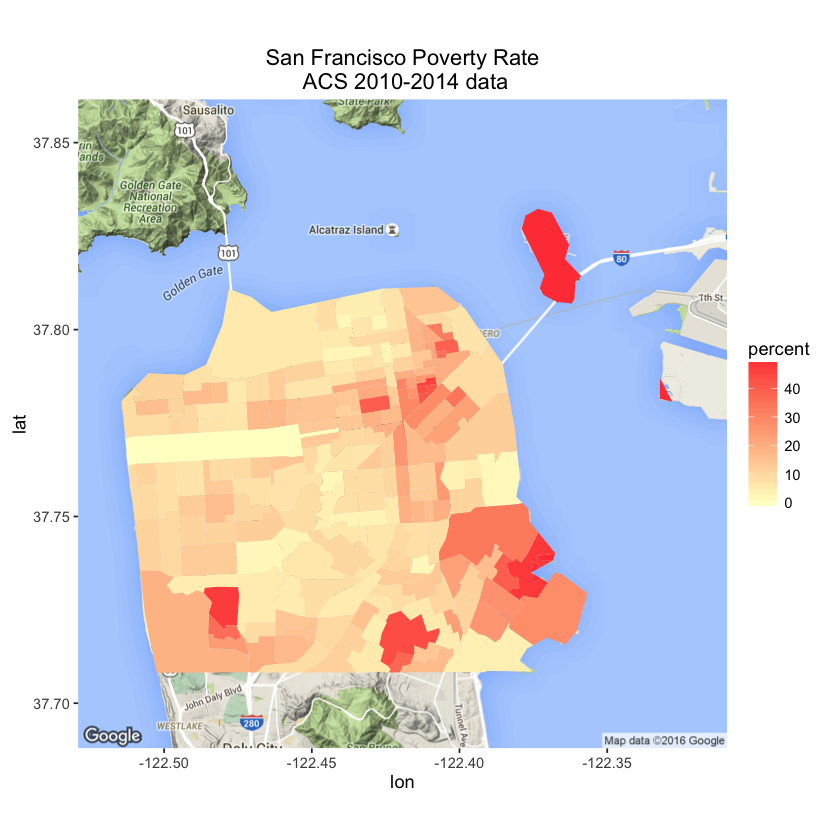

In [12]:
basemap <-get_map('San Francisco', zoom=12) 
ggmap(basemap) +
geom_polygon(data = ca_tract_sf , aes(x=long, y=lat, group = group, fill=percent)) +
scale_fill_gradient(low = "#ffffcc", high = "#ff4444") +
ggtitle('San Francisco Poverty Rate\n ACS 2010-2014 data')

In [14]:
ca_tract_alameda = ca_tract2[grep('Alameda',ca_tract2$GEO.display.label),]
dim(ca_tract_alameda)

[1] 8398   12

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=Hayward&zoom=10&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Hayward&sensor=false


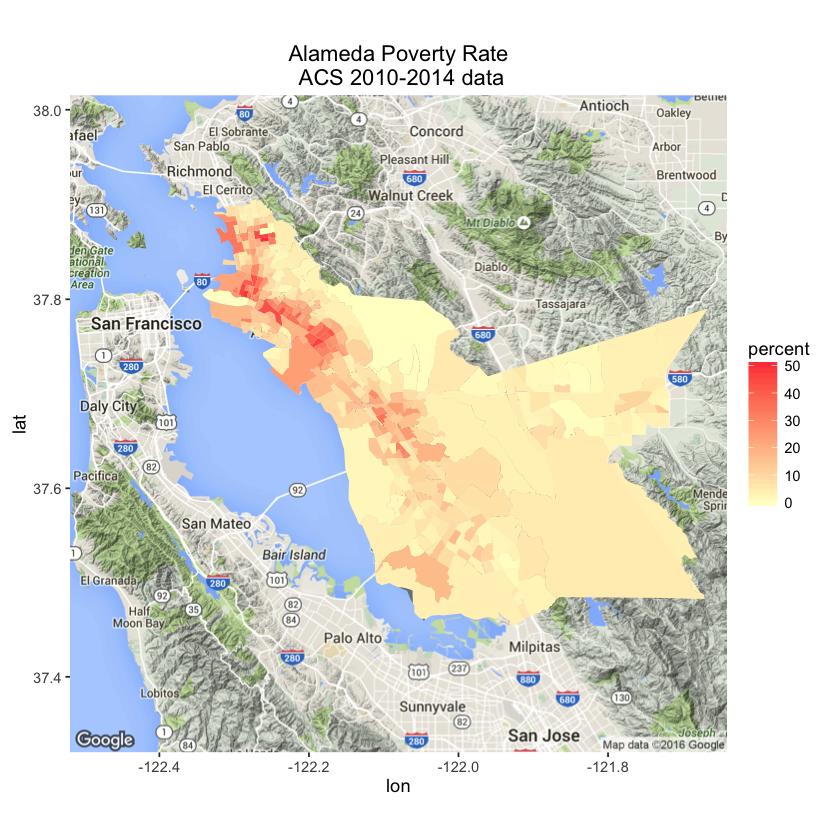

In [15]:
basemap <-get_map('Hayward', zoom=10) 
ggmap(basemap) +
geom_polygon(data = ca_tract_alameda , aes(x=long, y=lat, group = group, fill=percent)) +
scale_fill_gradient(low = "#ffffcc", high = "#ff4444") +
ggtitle('Alameda Poverty Rate\n ACS 2010-2014 data')

In [16]:
ca_tract_sanmateo = ca_tract2[grep('San Mateo',ca_tract2$GEO.display.label),]
dim(ca_tract_sanmateo)

[1] 5235   12

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=San+Mateo&zoom=10&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San%20Mateo&sensor=false


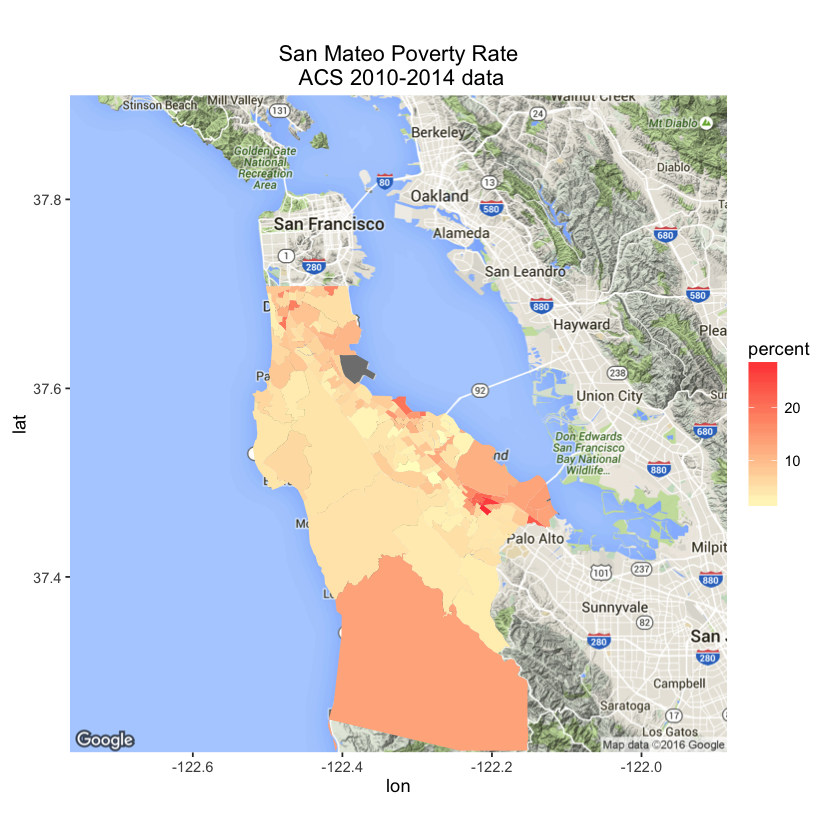

In [18]:
basemap <-get_map('San Mateo', zoom=10) 
ggmap(basemap) +
geom_polygon(data = ca_tract_sanmateo , aes(x=long, y=lat, group = group, fill=percent)) +
scale_fill_gradient(low = "#ffffcc", high = "#ff4444") +
ggtitle('San Mateo Poverty Rate\n ACS 2010-2014 data')

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=San+Leandro&zoom=11&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San%20Leandro&sensor=false


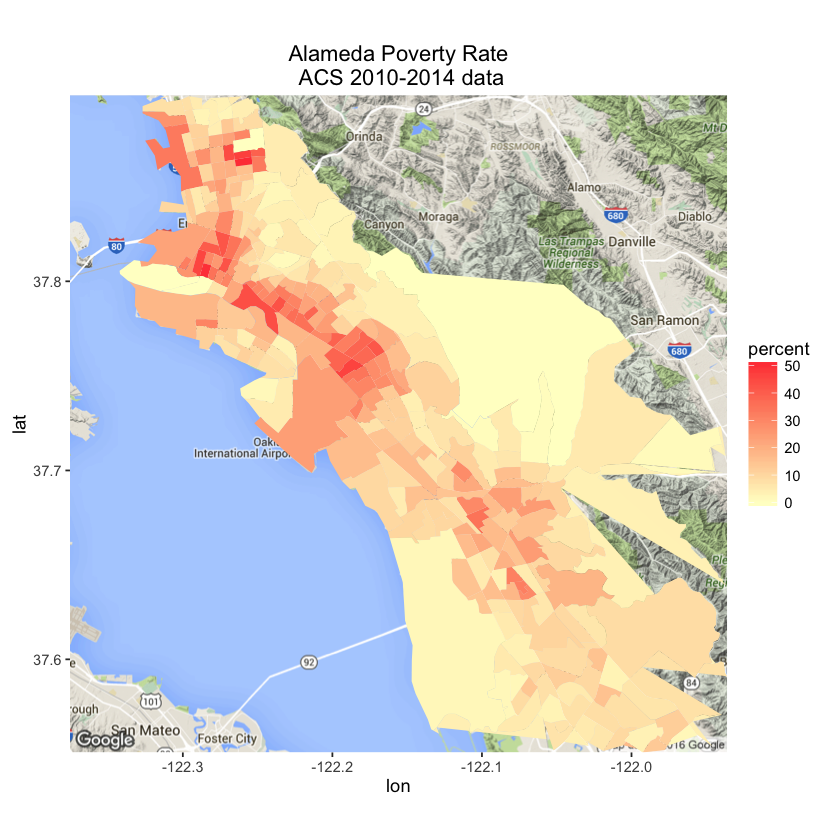

In [19]:
#zoom in on oakland and san leandro
basemap <-get_map('San Leandro', zoom=11) 
ggmap(basemap)+
geom_polygon(data = ca_tract_alameda , aes(x=long, y=lat, group = group, fill=percent)) +
scale_fill_gradient(low = "#ffffcc", high = "#ff4444") +
ggtitle('Alameda Poverty Rate\n ACS 2010-2014 data')